# Montecarlo Approximation of Electron-Matter-Interaction

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from fastai.vision.all import * 
import fastai
import torch
print("sys.version", sys.version)
print("cuda device name(0)", torch.cuda.get_device_name(0))
print("torch.__version__", torch.__version__)
print("fastai.__version__", fastai.__version__)

sys.version 3.9.15 (main, Nov 24 2022, 14:31:59) 
[GCC 11.2.0]
cuda device name(0) Tesla V100S-PCIE-32GB
torch.__version__ 1.12.1
fastai.__version__ 2.7.10


In [3]:
import pathlib
input_path = Path('./data')

def get_items(input_path):
    file_names = get_image_files(input_path)
    file_names = [filename for filename in file_names if "_hf.tif" in str( filename ) ]
    return file_names
    
file_names = get_items(input_path)    
print(file_names[0:5])

[Path('data/Sphere_Vv03_r10-15_Num1_BSE_110_hf.tif'), Path('data/Sphere_Vv07_r30-50_Num2_BSE_30_hf.tif'), Path('data/Sphere_Vv03_r30-50_Num1_BSE_70_hf.tif'), Path('data/Sphere_Vv03_r10-15_Num3_BSE_110_hf.tif'), Path('data/Sphere_Vv03_r30-50_Num1_BSE_150_hf.tif')]


## Datensatz laden

In [4]:
def get_hf(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_hf.tif" )
    return str(y)

def get_normal(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_normal.tif" )
    return str(y)

def get_bse(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_bse.tif" )
    return str(y)

def get_se(filename):
    filename_parts = str(filename.stem).split("_")
    y = input_path / Path( "_".join(filename_parts[:-1]) + "_se.tif" )
    return str(y)

for i in range(5):
    print(file_names[i], "/", get_normal(file_names[i]), "/", get_bse(file_names[i]))

data/Sphere_Vv03_r10-15_Num1_BSE_110_hf.tif / data/Sphere_Vv03_r10-15_Num1_BSE_110_normal.tif / data/Sphere_Vv03_r10-15_Num1_BSE_110_bse.tif
data/Sphere_Vv07_r30-50_Num2_BSE_30_hf.tif / data/Sphere_Vv07_r30-50_Num2_BSE_30_normal.tif / data/Sphere_Vv07_r30-50_Num2_BSE_30_bse.tif
data/Sphere_Vv03_r30-50_Num1_BSE_70_hf.tif / data/Sphere_Vv03_r30-50_Num1_BSE_70_normal.tif / data/Sphere_Vv03_r30-50_Num1_BSE_70_bse.tif
data/Sphere_Vv03_r10-15_Num3_BSE_110_hf.tif / data/Sphere_Vv03_r10-15_Num3_BSE_110_normal.tif / data/Sphere_Vv03_r10-15_Num3_BSE_110_bse.tif
data/Sphere_Vv03_r30-50_Num1_BSE_150_hf.tif / data/Sphere_Vv03_r30-50_Num1_BSE_150_normal.tif / data/Sphere_Vv03_r30-50_Num1_BSE_150_bse.tif


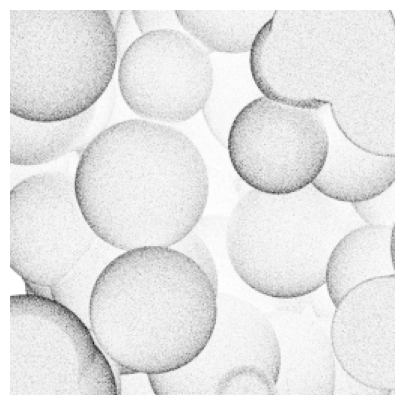

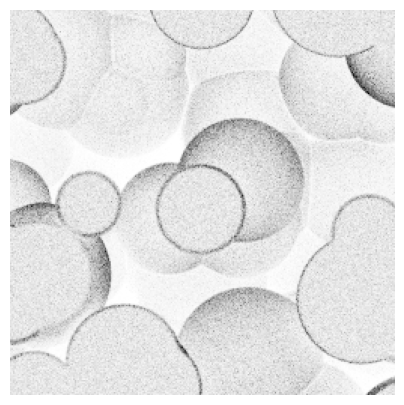

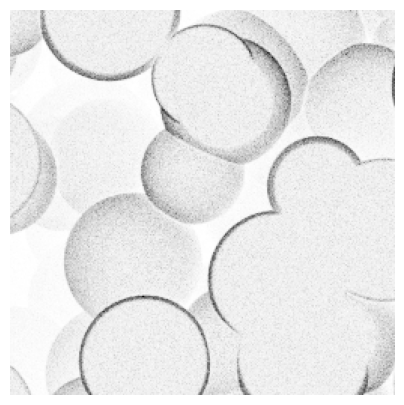

In [5]:
item_transforms  = [RandomCrop((256,256)),DihedralItem]

datablocks = DataBlock(blocks=(ImageBlock(cls=PILImageBW), ImageBlock, ImageBlock(cls=PILImageBW), ImageBlock(cls=PILImageBW)),
                       n_inp=2,
                       get_items=get_items,
                       getters=[get_hf,get_normal,get_bse,get_se],
                       splitter=RandomSplitter(valid_pct=0.2, seed=42),
                       item_tfms=item_transforms)

data_loader = datablocks.dataloaders(input_path, bs=3, num_workers=0 )

data_loader.show_batch( max_n=8 )

# Netzwerk Architektur

In [6]:
def create_inner_model( dataloader, backbone, **kwargs ):
    img_size = dataloader.one_batch()[0].shape[-2:]
    model = create_unet_model(backbone, 2, img_size, **kwargs)
    return model

class FIBModel(torch.nn.Module):
    def __init__(self, inner_model):
        super().__init__()
        self.inner_model = inner_model
        
    def forward(self, x_hf, x_normal):
        x = x_normal
        x[:,2,:,:] = x_hf[:,0,:,:]
        output_of_inner_model = self.inner_model(x)
        output = torch.split(output_of_inner_model, 1, dim=1)
        # output = output_of_inner_model
        return output

## Determine Learning Rate

In [7]:
# learner.save("custom_initial")
# learner.lr_find()

In [8]:
learning_rate=0.001

## Adding noise

In [9]:
from skimage.util import random_noise

def add_noise( img, var ):
    return torch.tensor( random_noise(img, mode='gaussian', mean=0, var=var, clip=True) )

def estimate_snr( img ):
    return img.mean() / img.std();

## Loss Function

In [10]:
class CombinedLoss():
    def __init__(self, losses, reduction='mean', axis=-1):
        self.losses = losses
        self._reduction = reduction
        self.axis = axis
        
    def __call__(self, out, *yb):
        total_loss = 0.0
        # out = torch.split(out, 1, dim=1)
        for i,loss_fct in enumerate( self.losses ):
            loss_fct.reduction = 'none'
            total_loss += loss_fct(out[i], yb[i])
        if self.reduction == "mean":
            total_loss = total_loss.mean()
        elif self.reduction == "sum":
            total_loss = total_loss.sum()
        return total_loss
    
    @property
    def reduction(self) -> str:
        return self._reduction    
    
    @reduction.setter
    def reduction(self, reduction:str):
        self._reduction = reduction  
    
    def decodes(self, x:Tensor) -> Tensor:    
        return x
        # return x.argmax(dim=self.axis)
    
    def activation(self, x:Tensor) -> Tensor:                 
        activation = torch.zeros(x[0].shape)
        for xi in list(x):
            activation += F.softmax(xi, dim=self.axis)    
        return activation
    
combined_loss = CombinedLoss([ L1LossFlat(), L1LossFlat()] )    

## Learner

In [11]:
from torchvision.models import *

train = False

# for backbone, backbone_name in [ (resnet101, "resnet101"), (resnet34,"resnet34"), (resnet50,"resnet50") ]:
for backbone, backbone_name in [ (resnet101, "resnet101") ]:
    print(backbone_name)
    model = FIBModel( create_inner_model( data_loader, backbone ) )
    learner = Learner( data_loader, model, loss_func=combined_loss )
    if train:
        learner.fit_one_cycle( 100, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
        learner.save(backbone_name + "100")
    else:
        learner.load(backbone_name + "100")
        
    # learner.fit_one_cycle( 50, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
    # leaner.save(backbone_name + "100")
    # learner.fit_one_cycle( 100, lr_max=learning_rate, cbs=[ShowGraphCallback()] )    
    # leaner.save(backbone_name + "200")
    # print( learner.recorder.final_record )

resnet101


/home/tida01/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/tida01/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
import matplotlib as mp
cpts = [0.0, 127.0/255.0, 1.0]
colors = [(cpts[0], (0, 0, 1.0)), (cpts[1], (0, 1.0, 0.0)), (cpts[2], (1.0, 0, 0))]
cmap_name = 'my_list'
colormap = mp.colors.LinearSegmentedColormap.from_list(cmap_name, colors)

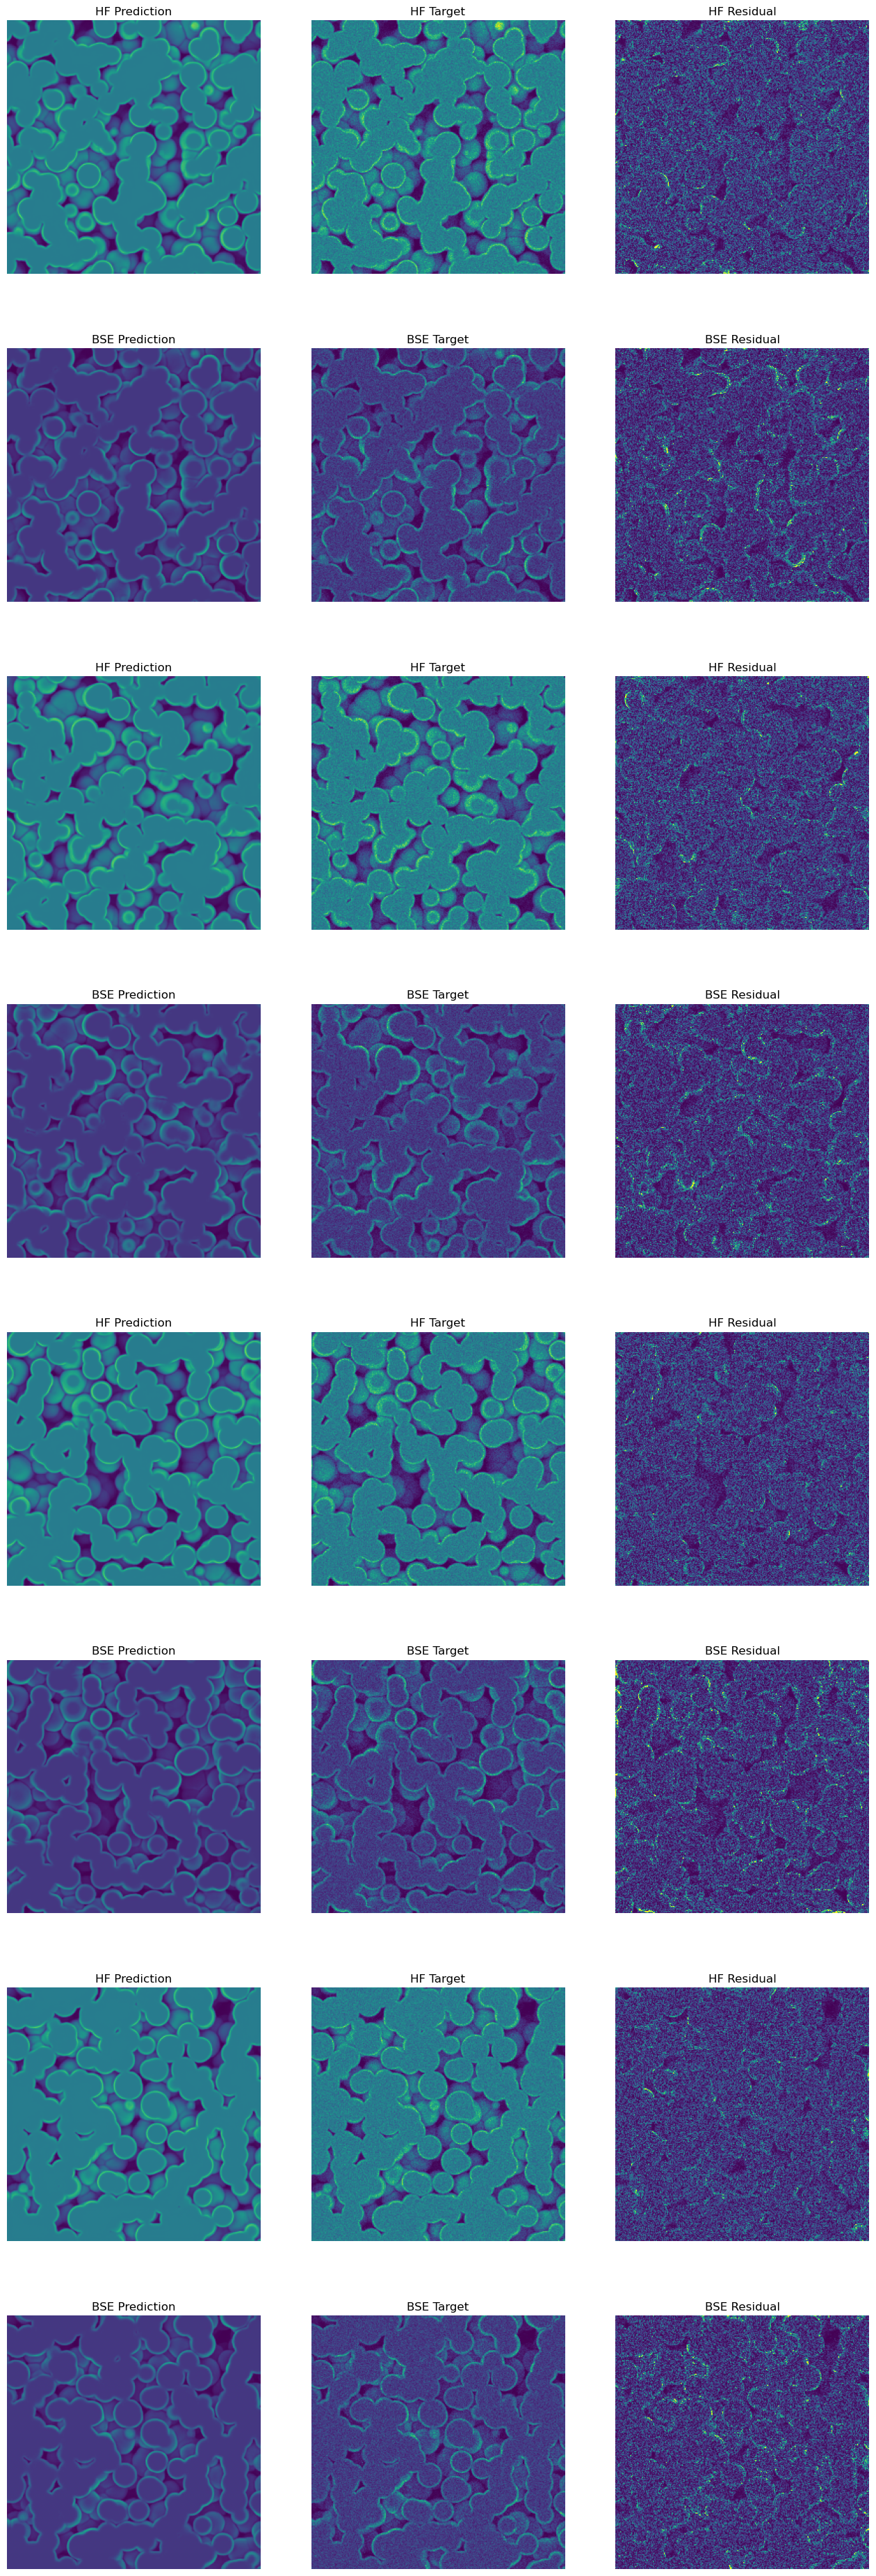

In [40]:
def filler(depth = 0):
    result = ""
    for i in range(depth):
        result = result + "  "
    return result

def print_tuple(x, depth = 0):
    if isinstance(x,fastai.torch_core.TensorBase):
        print(filler(depth), type(x), x.shape)
    elif isinstance(x,torch.Tensor):
        print(filler(depth), type(x), x.shape)
    elif type(x) is tuple:
        print(filler(depth), type(x), len(x) )
        for child_x in list(x):
            print_tuple( child_x, depth+1 )
    else:
        print(filler(depth), type(x))

class ConstantFunc():
    "Returns a function that returns `o`"
    def __init__(self, o): self.o = o
    def __call__(self, *args, **kwargs): return self.o        
        
class PredictionsFromTupleCallback(Callback):    
    def before_validate(self):
        self.preds = []
        self.targets = []
            
    def after_pred(self, **kwargs:Any)->None:
        se,bse = self.pred
        se = to_detach(se)
        bse = to_detach(bse)
        self.preds.append((se,bse))
        self.targets.append(self.yb)
        
from torchvision.utils import save_image

interpretation = Interpretation.from_learner( learner )
values,indices = interpretation.top_losses(k=4)

tmp_data_loader = learner.dls[1].new( get_idxs = ConstantFunc( indices ), bs=1 )
cb = PredictionsFromTupleCallback()
ctx_mgrs = learner.validation_context(cbs=[cb])
with ContextManagers(ctx_mgrs):
    learner._do_epoch_validate(dl=tmp_data_loader)

all_predictions = cb.preds
all_targets     = cb.targets
    
fig, axs = plt.subplots(2*4, 3, figsize=(16,48))

for i,idx in enumerate(indices):
    # hf_preds,bse_preds = preds
    hf_pred,bse_pred = all_predictions[i]
    hf_pred  = torch.squeeze( hf_pred, 0 )
    bse_pred = torch.squeeze( bse_pred, 0 )

    hf_target,bse_target = all_targets[i]
    hf_target  = torch.squeeze(  hf_target, 0 )
    bse_target = torch.squeeze( bse_target, 0 )
        
    hf_resid  = abs(hf_pred.cpu() - hf_target.cpu())
    bse_resid = abs(bse_pred.cpu() - bse_target.cpu())
    
    # noisy_hf =  add_noise( hf_preds, 0.0025 )
    # noisy_bse = add_noise( bse_preds, 0.0025 )
    
    # noisy_hf_resid = abs(noisy_hf - hf_target)
    # noisy_bse_resid = abs(noisy_bse - bse_target)
    
    # show_image( ax=axs[i,0], im=inps_hf,  title="Heightfield")
    # show_image( ax=axs[i,1], im=inps_n,  title="Normal")
    
    show_image( ax=axs[2*i  ,0], im=hf_pred,        title="HF Prediction", vmin=0, vmax=1)
    show_image( ax=axs[2*i+1,0], im=bse_pred,       title="BSE Prediction", vmin=0, vmax=1)

    show_image( ax=axs[2*i  ,1], im=hf_target,      title="HF Target", vmin=0, vmax=1)
    show_image( ax=axs[2*i+1,1], im=bse_target,     title="BSE Target", vmin=0, vmax=1)
    
    show_image( ax=axs[2*i,  2], im=hf_resid,       title="HF Residual", vmin=0, vmax=0.25)
    show_image( ax=axs[2*i+1,2], im=bse_resid,      title="BSE Residual", vmin=0, vmax=0.25)
    
plt.savefig("dual_task_top_losses.png", dpi=300)    